# **Applied AI in Biomedicine - Final Assignment**
## PAC/PVC classification from ECG signals
***
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*
***

In [1]:
#@title Set up the environment
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import tarfile
import math
import random
import sklearn
import timeit
import json
import warnings
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing 

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

Using Tensorflow version 2.6.0
RNG seed: 69


## Data loading

In [2]:
dataset_dir = "C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\AI in Biomedicine\\Workshop\\PAC-PVC-Beat-Classifier-for-ECGs\\data"

In [15]:
class Patient:
    def __init__(self,init_dict):
        self.path=init_dict['path']
        self.fs=init_dict['fs']
        self.id=init_dict['id']
        self.rpeaks=init_dict['rpeaks']
        self.peaklabels=init_dict['peaklabels']
        self.samples=init_dict['samples']
        self.time=np.arange(0,self.samples/self.fs,1/self.fs)
        self.lead1=init_dict['lead1']
        self.lead2=init_dict['lead2']
        if self.fs != 128:
            f1 = scipy.interpolate.interp1d(self.time,self.lead1)
            f2 = scipy.interpolate.interp1d(self.time,self.lead2)
            self.time=np.arange(0,self.samples/self.fs,1/self.fs)
            self.fs = 128.0
            self.lead1 = f1(self.time)
            self.lead2 = f2(self.time)
        
    def info(self):
        print(">> ID:",self.id)
        print(" | Path:",self.path)
        print(" | fs:",self.fs)
        print(" | samples:",self.samples)
        print(" | lead1:",self.lead1)
        print(" | lead2:",self.lead2)
        print(" | rpeaks:",self.rpeaks)
        print(" | peaklabels:",self.peaklabels)
        
    def plot(self,windowstart=None,xrange=4000):
        if windowstart is None: windowstart = randint(0,self.samples-xrange)
        
        plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead1,color='#073b4c')
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='N']],
            color='#06d6a0',s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='S']],
            color='#ef476f',s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='V']],
            color='#ffd166',s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title("ECG lead 1")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        
        plt.figure(figsize=(10,2.5))
        plt.plot(self.time,self.lead2,color='#073b4c')
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='N']],
            color='#06d6a0',s=500,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='S']],
            color='#ef476f',s=500,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='V']],
            color='#ffd166',s=500,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title("ECG lead 2")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    # Aggiungere parametro width,
    def split_RRR(self,borders=0.05,fixed_length=150):
        border_samples = round(borders*(self.rpeaks[0]))
        
        wl1 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        wl2 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        
        for p in range(1,self.rpeaks.shape[0]-1):
            border_samples = round(borders*(self.rpeaks[p+1]-self.rpeaks[p-1]))
            window = self.lead1[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl2.append(window)
        
        border_samples = round(borders*(self.rpeaks[0]))
        wl1.append(self.lead1[self.rpeaks[-1]:self.samples])
        wl2.append(self.lead1[self.rpeaks[-1]:self.samples])
        
        if fixed_length != False:
            r1,r2 = [],[]
            for i,_ in enumerate(wl1):
                if wl1[i].shape[0] > fixed_length:
                    r1.append(
                        wl1[i][wl1[i].shape[0]//2-fixed_length//2:wl1[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                    r2.append(
                        wl2[i][wl2[i].shape[0]//2-fixed_length//2:wl2[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                elif wl1[i].shape[0] < fixed_length:
                    padleft  = (fixed_length-wl1[i].shape[0])//2
                    padright = fixed_length-padleft-wl1[i].shape[0]
                    r1.append(
                        np.pad(wl1[i], (padleft,padright), mode='edge')
                    )
                    r2.append(
                        np.pad(wl2[i], (padleft,padright), mode='edge')
                    )
            wl1,wl2 = r1,r2
        return wl1,wl2
        
    def split_windows(self, width=100):
        wl1,wl2=[],[]
        for p in range(self.rpeaks.shape[0]):
            window = self.lead1[(self.rpeaks[p]-width+width//2):(self.rpeaks[p]+width//2)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p]-width+width//2):(self.rpeaks[p]+width//2)]
            wl2.append(window)
        return wl1,wl2

In [16]:
files = os.listdir(dataset_dir)
p = []
correct,ncorrect=0,0
for f in range(0,len(files),3):
    try:
        recs = loadmat(os.path.join("data",files[f]))
        ann = loadmat(os.path.join("data",files[f+1]))
        rp =loadmat(os.path.join("data",files[f+2]))
        patient_as_dict={
                'id':files[f].split(".")[0].split("_")[0],
                'path':os.path.join("data",files[f]),
                'fs':float(files[f].split(".")[0].split("_")[1]),
                'samples':recs['ecg'][:,0].shape[0],
                'lead1':recs['ecg'][:,0],
                'lead2':recs['ecg'][:,1],
                'rpeaks':rp['rpeaks'].T[0],
                'peaklabels':ann['labels'] 
        }
        p.append(Patient(patient_as_dict))
        correct+=1
        
    except:
        ncorrect+=1
print(f"Loaded {correct} files correctly")
if ncorrect>0: print(f"!!!! Error in loading {ncorrect} files")

Loaded 105 files correctly


### Example of R-peaks labelling

`p[9].plot()`

`p[38].info()`

`p[38].plot(180*p[38].fs,30*p[38].fs)`

>> ID: S039
 | Path: data\S039_128.mat
 | fs: 128.0
 | samples: 230400
 | lead1: [-0.2  -0.23 -0.24 ... -0.36 -0.38 -0.43]
 | lead2: [0.08 0.1  0.08 ... 0.26 0.28 0.27]
 | rpeaks: [    86    187    292 ... 230161 230266 230371]
 | peaklabels: ['N' 'N' 'N' ... 'N' 'N' 'N']


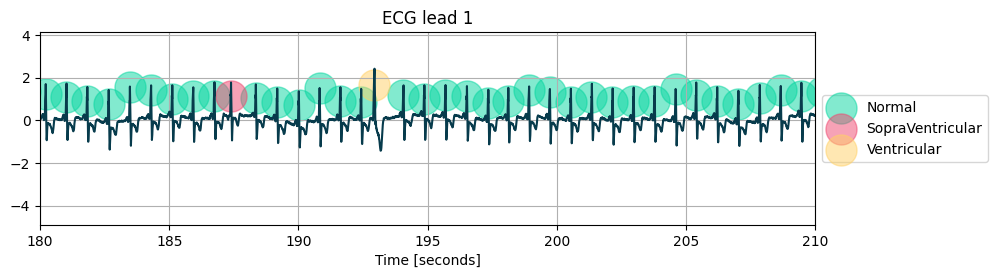

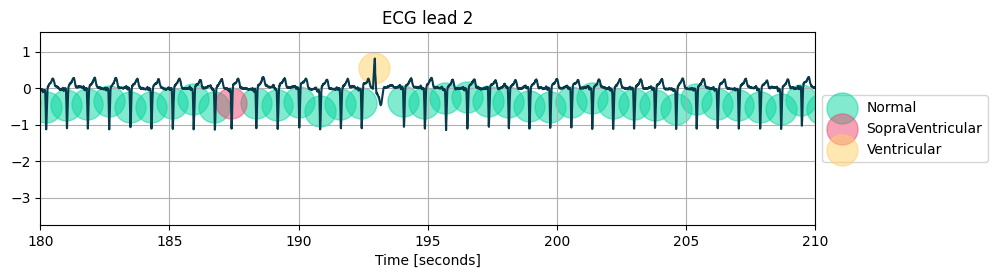

In [13]:
p[38].info()
p[38].plot(180*p[38].fs,30*p[38].fs)

Difference in splitting strategies:
* **Split_window** makes sure that windows are all of the same lenght and that the R-peak is exactly in the middle of the window, but multiple  
* **Split_RRR(fixed_length==False)** is sure to keep to the only desired R-peak in the window --> Inconsistency in window length
* **Split_RRR(fixed_length==True)** makes sure that windows are all of the same lenght and that only 1 peak is present in the window, but windows need to get padded and sliced to be adapted to the correct width 

2731
2731
2731


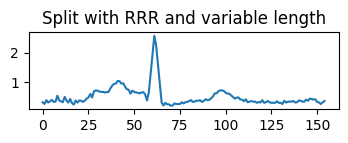

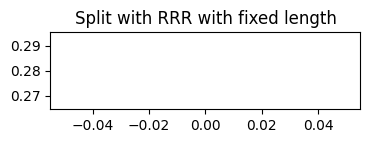

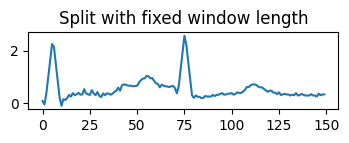

In [27]:
ptest = p[9]
idx = randint(0,1000)
split1,_ = ptest.split_RRR(fixed_length=False)
plt.figure(figsize=(4,1))
plt.plot(split1[idx])
print(len(split1))
plt.title("Split with RRR and variable length")

split1,_ = ptest.split_RRR(borders=0,fixed_length=True)
plt.figure(figsize=(4,1))
print(len(split1))
plt.plot(split1[idx])
plt.title("Split with RRR with fixed length")

split1,_ = ptest.split_windows(width=150)
plt.figure(figsize=(4,1))
print(len(split1))
plt.plot(split1[idx])
plt.title("Split with fixed window length")
plt.show()


In [7]:
split1,split2 = ptest.split_RRR()
wlens=[w.shape[0] for w in split1]
len(split1)

2731

Preprocessing:
* numpy Interp1D per upsampling/downsampling
* Controllo NaN  e Outliers
* (Rescale su singola finestra)
* Cosa fare con finestre di different lenght?
Modelli: